In [1]:
!pip install timm -q
!pip install python-gdcm -q
!pip install pylibjpeg -q

In [2]:
import os
import cv2
import glob

import cv2
import numpy as np
import pandas as pd

from path import Path
from tqdm import tqdm
import pydicom as dicom

import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Reading Dicom Images

In [3]:
def load_dicom(path):
    img=dicom.dcmread(path)
    data=img.pixel_array       
    return data

def listdirs(folder):
    return [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]    

train_dir = '/kaggle/input/rsna-breast-cancer-detection/train_images'
test_dir = '/kaggle/input/rsna-breast-cancer-detection/test_images'
patients = sorted(os.listdir(train_dir))

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.10006.1.1874946579
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.10006.1.1874946579
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '183902.142082'
(0010, 0020) Patient ID                          LO: '10006'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.10006
(0020, 000e) Series Instance

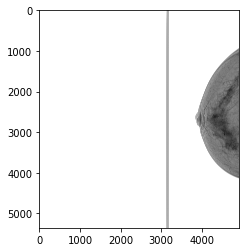

In [4]:
ds = dicom.dcmread("/kaggle/input/rsna-breast-cancer-detection/train_images/10006/1874946579.dcm")
plt.imshow(ds.pixel_array, cmap='gray')
# MetaData
print(ds)

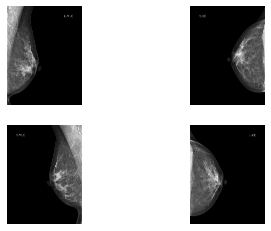

In [5]:
image_file = glob.glob("/kaggle/input/rsna-breast-cancer-detection/train_images/10011/*.dcm")
for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    image_path = image_file[i]
    image = load_dicom(image_path)
    plt.axis('off')   
    plt.imshow(image, cmap='gray')

# Train CSV

In [6]:
df = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")
df.head().style.background_gradient(cmap="Accent")

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.000000,0,0,0,nan,0,nan,29,False
1,2,10006,1459541791,L,MLO,61.000000,0,0,0,nan,0,nan,29,False
2,2,10006,1864590858,R,MLO,61.000000,0,0,0,nan,0,nan,29,False
3,2,10006,1874946579,R,CC,61.000000,0,0,0,nan,0,nan,29,False
4,2,10011,220375232,L,CC,55.000000,0,0,0,0.000000,0,nan,21,True


## Missing Values


In [7]:
missing_columns = [col for col in df.columns if df[col].isnull().any()]
missingvalues_count = df.isna().sum()
missingValues_df = pd.DataFrame(missingvalues_count.rename('Null Values Count')).loc[missingvalues_count.ne(0)]
missingValues_df .style.background_gradient(cmap="Pastel1")

,Null Values Count
age,37
BIRADS,28420
density,25236


In [8]:
df['cancer'].value_counts()

0    53548
1     1158
Name: cancer, dtype: int64

In [9]:
cancer = df[df['cancer'] == 1]
non_cancer = df[df['cancer'] == 0][:1200] #Taking only 1200 non-cancer images
frames = [cancer, non_cancer] 
train_df = pd.concat(frames)
train_df.head().style.background_gradient(cmap="Pastel1")

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
87,1,10130,388811999,L,MLO,71.000000,1,1,1,0.000000,0,B,49,False
88,1,10130,613462606,L,CC,71.000000,1,1,1,0.000000,0,B,49,False
89,1,10130,1360338805,L,CC,71.000000,1,1,1,0.000000,0,B,49,False
90,1,10130,1672636630,L,MLO,71.000000,1,1,1,0.000000,0,B,49,False
190,1,10226,461614796,L,MLO,71.000000,1,1,1,0.000000,0,C,49,False


In [10]:
train, val = train_test_split(train_df, test_size=0.15, stratify=train_df['cancer'])
train = train.reset_index()
val = val.reset_index()

In [11]:
class CancerDataset(Dataset):
    def __init__(self, df, transform=None):
        super(CancerDataset, self).__init__()
        self.df = df.copy()
        self.transform = transform
        self.path_to_dcms = "/kaggle/input/rsna-breast-cancer-detection/train_images"
        
    def __getitem__(self, idx):
        dcm_path = os.path.join(self.path_to_dcms, str(self.df.loc[idx, "patient_id"]), f"{self.df.loc[idx, 'image_id']}.dcm")
        dcm = dicom.dcmread(dcm_path)
        dcm = dcm.pixel_array.astype(np.float32)
        dcm = cv2.resize(dcm, (224,224))
        if self.transform:
            dcm = self.transform(dcm)
        label = self.df.loc[idx, "cancer"]
        label = torch.tensor(label, dtype=torch.int32)
        return dcm, label
    
    def __len__(self):
        return len(self.df)

In [12]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_loader = DataLoader(
    CancerDataset(train,transform=transform), 
    batch_size=16, 
    shuffle=False, 
    num_workers=1
)
val_loader = DataLoader(
    CancerDataset(val,transform=transform), 
    batch_size=16, 
    shuffle=False, 
    num_workers=1
)
dataloaders_dict = {"train": train_loader, "val": val_loader}
criterion = nn.CrossEntropyLoss()

In [13]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs):
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.cuda()
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_acc = 0
            
            dataloader = dataloaders_dict[phase]
            for item in tqdm(dataloader, leave=False):
                images = item[0].cuda().float()
                classes = item[1].cuda().long()

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    output = model(images)
                    loss = criterion(output, classes)
                    _, preds = torch.max(output, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * len(output)
                    epoch_acc += torch.sum(preds == classes.data)
                    

            data_size = len(dataloader.dataset)
            epoch_loss = epoch_loss / data_size
            epoch_acc = epoch_acc.double() / data_size

            print(f'Epoch {epoch + 1}/{num_epochs} | {phase:^5} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}')
        
        if epoch_acc > best_acc:
            traced = torch.jit.trace(model.cpu(), torch.rand(1, 1, 224, 224))
            traced.save('model.pth')
            best_acc = epoch_acc

In [14]:
import timm
model = timm.create_model('efficientnet_b4', pretrained=True, in_chans=1)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b4_ra2_320-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_ra2_320-7eb33cd5.pth


In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
train_model(model, dataloaders_dict, criterion, optimizer, 3)

Epoch 1/3 | train | Loss: 2.1074 | Acc: 0.4192


Epoch 1/3 |  val  | Loss: 0.8963 | Acc: 0.4944


Epoch 2/3 | train | Loss: 0.3584 | Acc: 0.8708


Epoch 2/3 |  val  | Loss: 0.9612 | Acc: 0.5028


Epoch 3/3 | train | Loss: 0.1201 | Acc: 0.9895


Epoch 3/3 |  val  | Loss: 1.1401 | Acc: 0.5141
